# Calibration of spectra
`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 28 Aug 2022

Adapted from HAP703P

References: *Handbook of CCD Astronomy* §6 ; *Handbook of Astronomical Spectroscopy* §6
* flat field correction of stellar and calibration spectra
* wavelength calibration of stellar spectra
* save spectra as FITS files

In [15]:
# import and settings
%matplotlib notebook
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import astropy.io.fits as pf
from astropy.modeling import models
from astropy.stats import mad_std
from astropy.table import QTable
from astropy import units as u
import pydis_um 
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget
from astropy.visualization import ZScaleInterval
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from astroplan import FixedTarget, Observer
from astropy.nddata import StdDevUncertainty
from pytz import timezone
import ccdproc as ccdp
from specutils.manipulation import LinearInterpolatedResampler
import specutils
import specutils.fitting as spf
from specutils.manipulation import extract_region
from specutils import Spectrum1D, SpectralRegion
from iraf_um import imstat

## Load previously computed data 

In [16]:
# define CCD characteristics
ccd_gain = 0.9709756374359131 * u.electron / u.adu
ccd_ron = 2.8359016154485057 * u.electron

In [17]:
# define file names
fname_sci = 'Master_M76_s1d.fit'
fname_rvstd = 'Master_ksi_Cas_s1d.fit'
# load spectra
sci_s1d = ccdp.CCDData.read('reduced/' + fname_sci)
rvstd_s1d = ccdp.CCDData.read('reduced/' + fname_rvstd)
mflat_s1d = ccdp.CCDData.read('reference/master_flat_s1d.fits')
mwcal_s1d = ccdp.CCDData.read('reference/master_wcal_s1d.fits')

## Normalise flat field and correct other frames

Fit RMS deviation = 0.178 e-


<IPython.core.display.Javascript object>


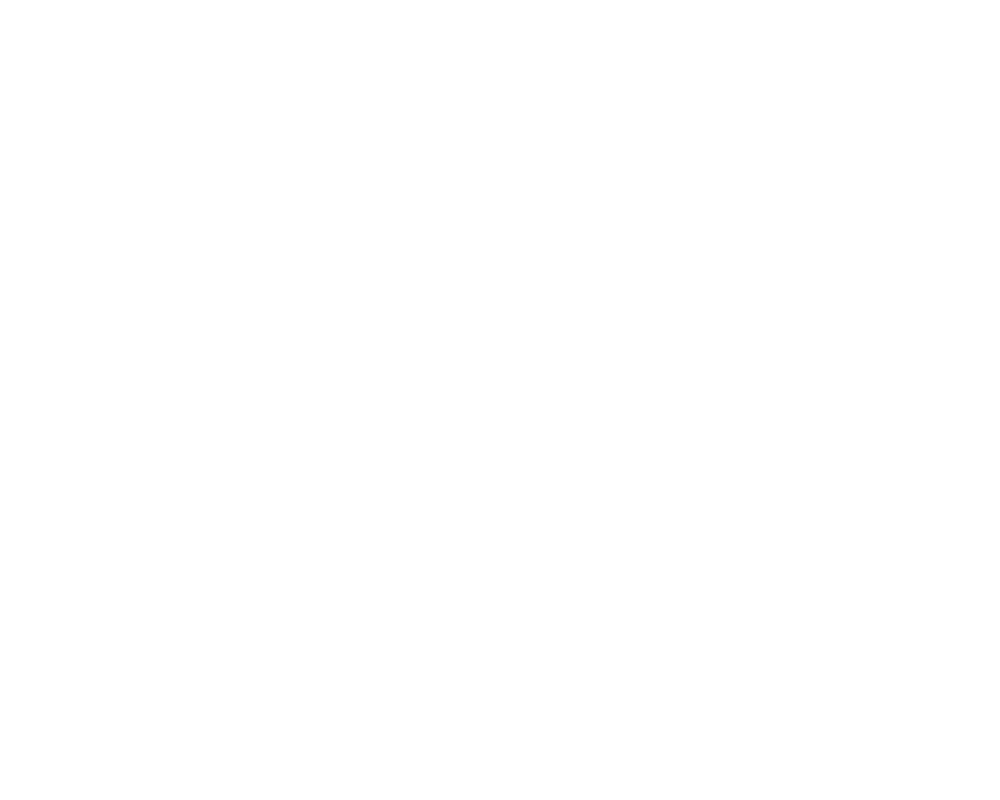

In [18]:
# normalise flat field to keep only small-scale variations
mflat_s1d_medfilt = sp.ndimage.median_filter(mflat_s1d.data, size=100)
x_ccd = np.linspace(0, mflat_s1d.data.shape[0],  mflat_s1d.data.shape[0])
mflat_coeff = np.polyfit(x_ccd, mflat_s1d.data, deg=4) #### MODIF Deg =3 -> Deg =4
mflat_fit = np.poly1d(mflat_coeff)(x_ccd)
mflat_n_s1d = mflat_s1d.data / mflat_fit
#
rms = np.sqrt(np.mean((mflat_fit - mflat_s1d.data)**2))
print("Fit RMS deviation = %.3f e-" % rms)

# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(mflat_s1d.data, c='tab:blue')
ax1.plot(mflat_fit, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Master flat field and polynomial fit')
#
ax2 = fig.add_subplot(212)
ax2.plot(mflat_n_s1d, c='tab:green')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('normalised master flat field')
#
plt.show()

<IPython.core.display.Javascript object>


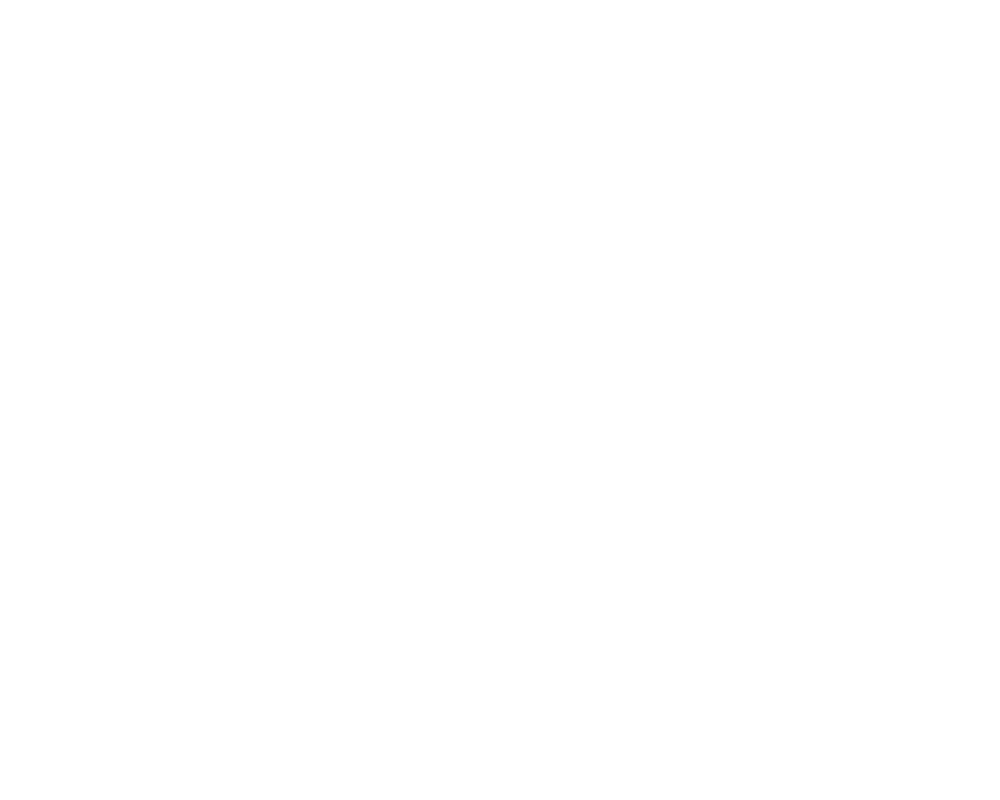

In [19]:
# apply flat field correction to science and rv std spectra
sci_f_s1d = sci_s1d.data / mflat_n_s1d
sig_sci_f_s1d = copy.deepcopy(sci_s1d.uncertainty)
#sig_sci_f_s1d /= mflat_n_s1d
#
rvstd_f_s1d = rvstd_s1d.data / mflat_n_s1d
sig_rvstd_f_s1d = copy.deepcopy(rvstd_s1d.uncertainty)
#sig_rvstd_f_s1d /= mflat_n_s1d


# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,8))
#
ax1 = fig.add_subplot(211)
ax1.plot(sci_s1d.data, c='tab:blue')
ax1.plot(sci_f_s1d, c='tab:orange')
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.set_title('Science spectrum before and after flat field correction')
#
ax2 = fig.add_subplot(212)
ax2.plot(rvstd_s1d.data, c='tab:blue')
ax2.plot(rvstd_f_s1d, c='tab:orange')
ax2.axvline(850, ls='--', c='k', lw=0.4)
ax2.set_title('RV Standard spectrum before and after flat field correction')
#
plt.show()

1756.4135932553131


<IPython.core.display.Javascript object>


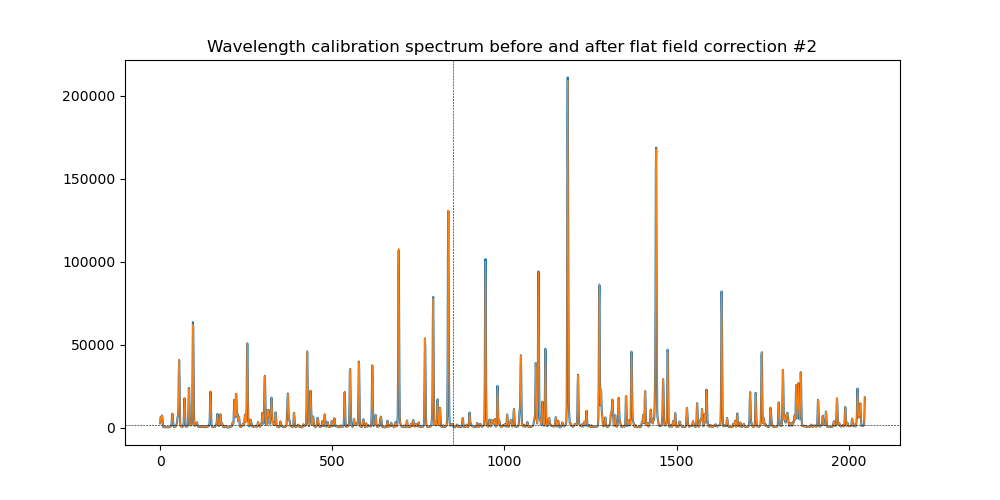

In [20]:
# apply flat field correction to wavelength calibration spectrum
## flat field normalised by polynomial fit
mwcal_f_s1d = mwcal_s1d.data / mflat_n_s1d
# compute baseline level
mwcal_base = np.median(mwcal_f_s1d[1100:])
print(mwcal_base)
# plot fit and result
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
#
ax1 = fig.add_subplot(111)
ax1.plot(mwcal_s1d.data, c='tab:blue')
ax1.plot(mwcal_f_s1d, c='tab:orange', lw=.8)
ax1.axvline(850, ls='--', c='k', lw=0.4)
ax1.axhline(mwcal_base, ls='--', c='k', lw=0.4)
ax1.set_title('Wavelength calibration spectrum before and after flat field correction #2')
#
plt.show()
# remove baseline level from wcal frame
mwcal_f_s1d -= mwcal_base

## Wavelength calibration

In [21]:
# convert wcal spectrum to a specutils.Spectrum1D instance
mwcal_f_s1d = specutils.Spectrum1D(mwcal_f_s1d.data*u.adu)

26 emission lines identified
line_center line_type line_center_index
    pix                                
----------- --------- -----------------
       54.0  emission                54
       95.0  emission                95
      252.0  emission               252
      426.0  emission               426
      551.0  emission               551
      577.0  emission               577
      616.0  emission               616
      692.0  emission               692
      769.0  emission               769
      792.0  emission               792
        ...       ...               ...
     1183.0  emission              1183
     1275.0  emission              1275
     1369.0  emission              1369
     1440.0  emission              1440
     1461.0  emission              1461
     1474.0  emission              1474
     1631.0  emission              1631
     1747.0  emission              1747
     1809.0  emission              1809
     1861.0  emission              1861
Length = 26

<IPython.core.display.Javascript object>


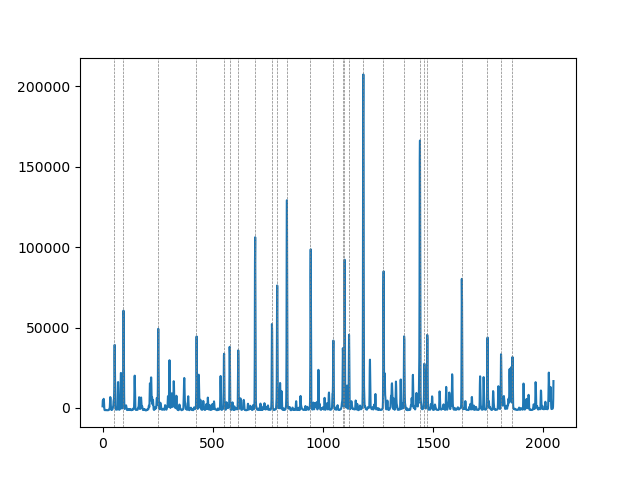

In [22]:
# detect spectral lines
#lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=1.e5)
lines = spf.find_lines_derivative(mwcal_f_s1d, flux_threshold=2.7e4)
lines[lines['line_type'] == 'emission']
print("%d emission lines identified" % len(lines))
print(lines)
# plot identified lines
plt.figure()
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    plt.axvline(l['line_center_index'], ls='--', c='grey', lw=0.5)
plt.show()

<IPython.core.display.Javascript object>


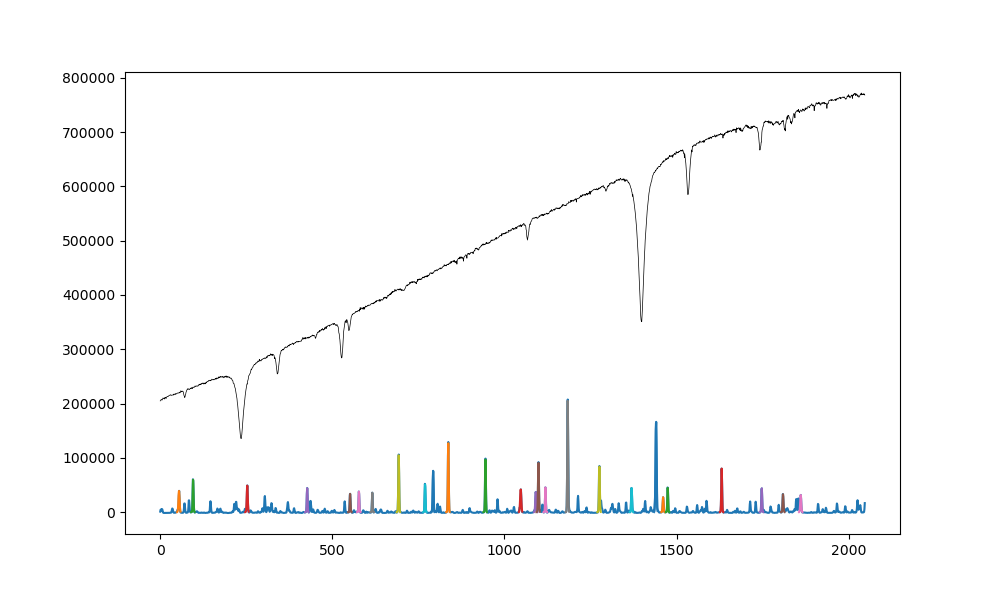

In [23]:
# fit each line w/ a gaussian model to retrieve the central pixel and fwhm
## overplot the RV std spectrum for reference
wcal_amp = []
wcal_x = []
wcal_std = []
plt.figure(figsize=(10,6))
plt.plot(rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(mwcal_f_s1d.flux)
for l in lines:
    sub_region = SpectralRegion((l['line_center_index']-4)*u.pix, (l['line_center_index']+4)*u.pix)
    sub_spectrum = extract_region(mwcal_f_s1d, sub_region)
    g = spf.estimate_line_parameters(sub_spectrum, models.Gaussian1D())
    wcal_amp.append(g.amplitude.value)
    wcal_x.append(g.mean.value)
    wcal_std.append(g.stddev.value)
    xx = np.linspace((l['line_center_index']-5)*u.pix,(l['line_center_index']+5)*u.pix,22)
    plt.plot(xx, g(xx))
plt.show()

In [24]:
# associate two observed lines to tabulated ThAr lines and compute preliminary solution
wcal_lam = -1. * np.ones_like(wcal_x)
wcal_lam[7] = 4391.11 # Ar
wcal_lam[17] = 4609.55 # Ar
# linear solution lam = a*x + b
a = (wcal_lam[7] - wcal_lam[17]) / (wcal_x[7] - wcal_x[17])
b = wcal_lam[17] - a*wcal_x[17]
print('a = ', a*u.AA, ' ; b = ', b*u.AA)
lam0 = a*mwcal_f_s1d.spectral_axis.value + b

a =  0.37463564022100393 Angstrom  ; b =  4131.5220115896245 Angstrom


<IPython.core.display.Javascript object>


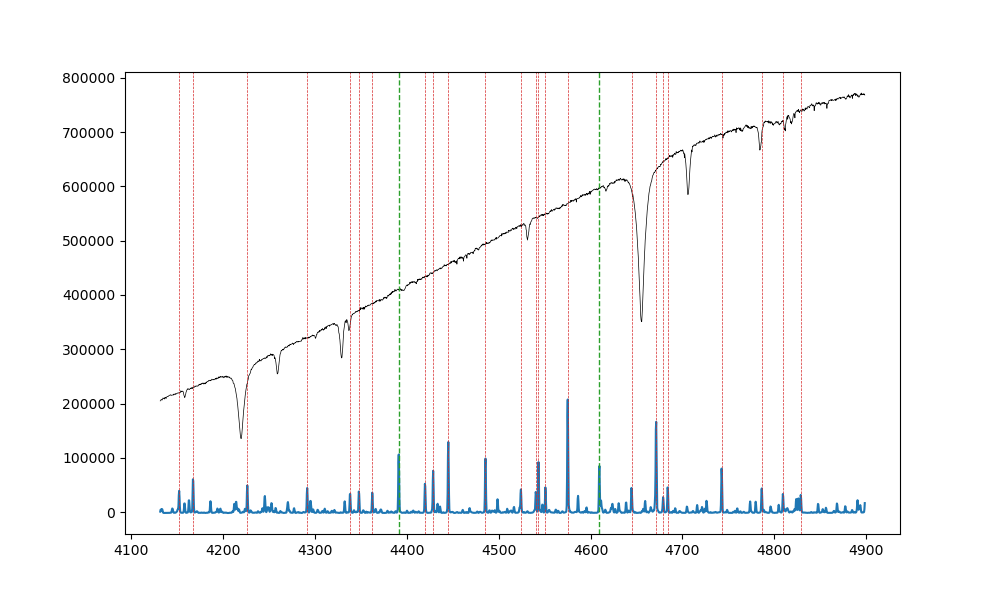

In [25]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam0, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam0, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(a*x+b, ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(a*x+b, ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(a*x+b, ls='--', c='grey', lw=0.5)

plt.show()

In [26]:
# identify more lines
# iterate from here until all useful lines are identified
wcal_lam = -1. * np.ones_like(wcal_x)
wcal_lam[0] = 4259.36
#wcal_lam[1] = 4272.17
#wcal_lam[2] = 4289.04 #?
#wcal_lam[3] = 4300.10
#wcal_lam[4] = 4312.99
#wcal_lam[2] = 4348.06
#wcal_lam[6] = 4370.75
#wcal_lam[7] = 4391.11
wcal_lam[3] = 4426.01
#wcal_lam[9] =
#wcal_lam[10] = 4474.77
#wcal_lam[11] = 
wcal_lam[5] = 4493.33
wcal_lam[6] = 4510.74
wcal_lam[7] = 4545.05
wcal_lam[8] = 4579.35
wcal_lam[9] = 4589.90
#wcal_lam[17] =
wcal_lam[10] = 4609.55
wcal_lam[11] = 4657.94
#wcal_lam[20] = 4673.66
#wcal_lam[12] = 4703.99
#wcal_lam[22] = 
wcal_lam[14] = 4726.86
#wcal_lam[24] = 4735.91
#wcal_lam[25] = 
#wcal_lam[15] = 4778.30
wcal_lam[17] = 4806.02
#wcal_lam[18] = 4847.82
#wcal_lam[29] = 4865.48
#wcal_lam[19] = 4879.88
#wcal_lam[31] = 
wcal_lam[21] = 4894.96
#wcal_lam[33] = 4945.47
wcal_lam[22] = 4965.07
#wcal_lam[35] = 5002.10
#wcal_lam[36] = 
wcal_lam[23] = 5017.26
#wcal_lam[24] = 5044.73
#wcal_lam[39] =
#wcal_lam[40] = 
wcal_lam[25] = 5067.97
#wcal_lam[42] = 5141.79

[54.59072515849901, 427.0321124010708, 577.3437249613988, 616.2418691220239, 692.9078831294324, 769.4761824431921, 792.897571980945, 836.9375218429363, 944.9314038052618, 1098.946539410475, 1275.9810789181167, 1474.4731205852108, 1631.2550417700452, 1747.6983961909757, 1860.9048213731392] [4259.36, 4426.01, 4493.33, 4510.74, 4545.05, 4579.35, 4589.9, 4609.55, 4657.94, 4726.86, 4806.02, 4894.96, 4965.07, 5017.26, 5067.97]


<IPython.core.display.Javascript object>


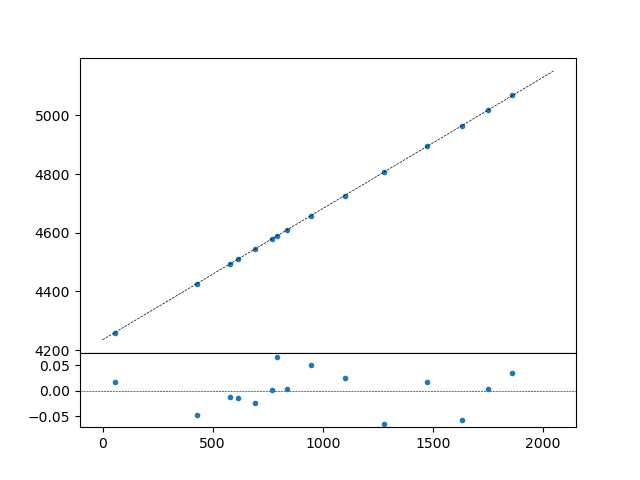

RMS = 0.0367 pix (nlines=15/ndf=12)


In [27]:
# create lists w/ only lines to fit
x_fit = [x for x,l in zip(wcal_x, wcal_lam) if l > 1.]
lam_fit = [l for l in wcal_lam if l > 1.]
print(x_fit, lam_fit)
# polynomial fit for wavelength solution
deg_wcal = 2 # set degree of wavelength calibration polynomial
wcal_coeff = np.polyfit(x_fit, lam_fit, deg=deg_wcal)
lam1 = np.poly1d(wcal_coeff)(mwcal_f_s1d.spectral_axis.value)
# plot fit and residual
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
fig.subplots_adjust(hspace=0)
# main plot
ax1.plot(x_fit, lam_fit, marker='o', ms=3., color='tab:blue', ls='')
ax1.plot(mwcal_f_s1d.spectral_axis.value, lam1, c='k', ls='--', lw=0.5)
# residual 'O-C'
res = lam_fit - np.poly1d(wcal_coeff)(x_fit)
ax2.axhline(0., ls='--', c='k', lw=0.4)
ax2.plot(x_fit, res, 'o', c='tab:blue', ms=3.)
#ax2.set_xlim(0,1.e3)
#plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()
# Compute and print RMS
rms = np.sqrt(np.mean(res**2))
print("RMS = %.4f pix (nlines=%d/ndf=%d)" % (rms, len(x_fit), len(x_fit)-(deg_wcal+1)))

<IPython.core.display.Javascript object>


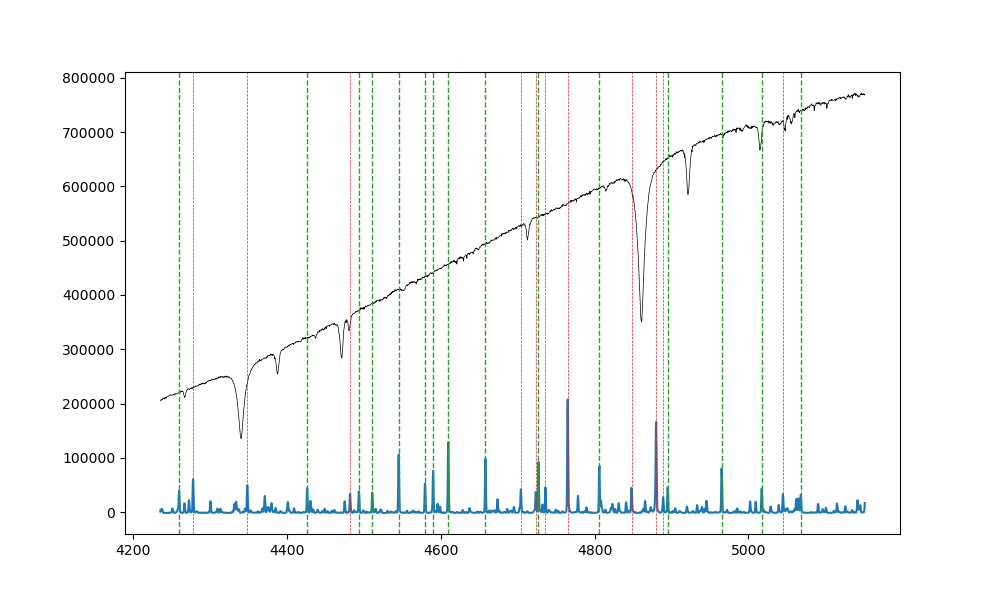

In [28]:
# Re-plot spectrum w/ this first solution and identify other lines
plt.figure(figsize=(10,6))
plt.plot(lam1, rvstd_f_s1d*5.e5/np.mean(rvstd_f_s1d), c='k', lw=0.5)
plt.plot(lam1, mwcal_f_s1d.flux)
for i, x in enumerate(wcal_x):
    if wcal_lam[i] > 1.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:green', lw=1.)
    elif wcal_lam[i] < 0.:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='tab:red', lw=0.5)
    else:
        plt.axvline(np.poly1d(wcal_coeff)([x]), ls='--', c='grey', lw=0.5)
#plt.xlim(3500., 8000.)
plt.show()

In [29]:
#Estimation résolution

R_list = [np.poly1d(wcal_coeff)(wcal_x[i])/(2*(np.poly1d(wcal_coeff)(wcal_std[i])-wcal_coeff[2])) for i in range(len(wcal_x))]
print(np.cumsum(R_list)[len(R_list)-1]/len(R_list))

4150.67820880072


## Apply redshift + combine spectrums

<IPython.core.display.Javascript object>


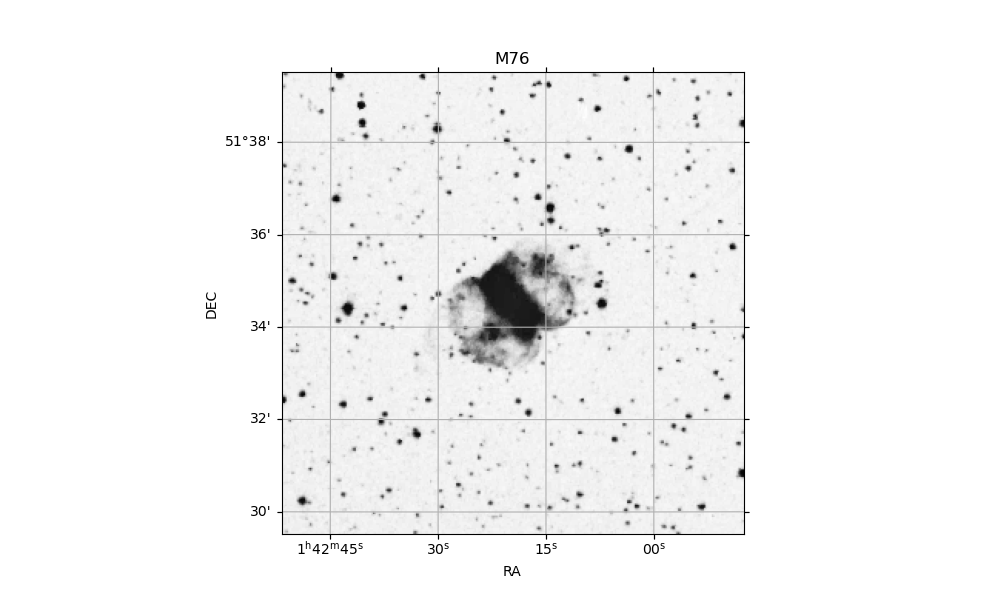

In [15]:
#Image de M76
plt.figure(figsize=(10,6))
M76 = FixedTarget.from_name('M76')
ax, hdu = plot_finder_image(M76)
plt.show()

<IPython.core.display.Javascript object>


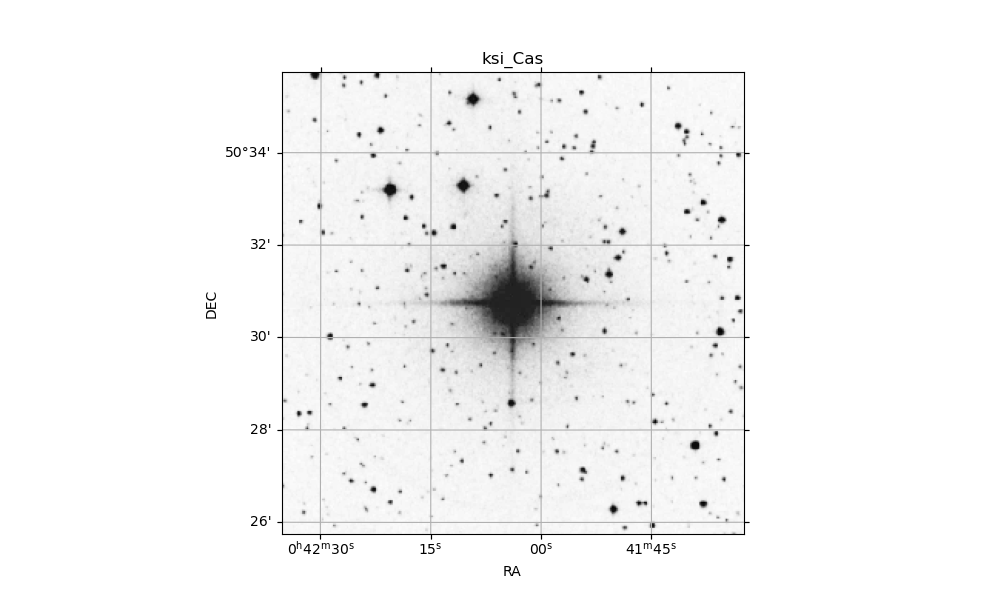

In [16]:
#Image de ksi_Cas
plt.figure(figsize=(10,6))
ksi_Cas = FixedTarget.from_name('ksi_Cas')
ax, hdu = plot_finder_image(ksi_Cas)
plt.show()

In [17]:
#Calcul du redshift

longitude = 5.712222 * u.deg
latitude = 43.931667 * u.deg
elevation = 650. * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
observer = Observer(name='OHP',
                    location=location,
                    timezone=timezone('UTC'))

z_M76=[]
z_ksi_Cas=[]


time = Time(rvstd_s1d.header['date'])
z_ksi_Cas.append(ksi_Cas.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à Ksi_Cas est : "+str(z_ksi_Cas))
print('\n')


time = Time(sci_s1d.header['date'])
z_M76.append(M76.coord.radial_velocity_correction(kind='barycentric', obstime=time, location=location).to(u.km/u.s))#/(3.e5 * u.km/u.s))
print("Le redshift associé à M76 est : "+str(z_M76))


Les redshifts associés aux Ksi_Cas sont : [<Quantity 12.89765883 km / s>]


Les redshifts associés aux M76 sont : [<Quantity 17.09698759 km / s>]


## Apply wavelength calibration to science and RV standard spectra + save to FITS

In [18]:
# Save science spectrum as a fits file
## primary HDU contains header from parent file
prihdu_sci_fw = pf.PrimaryHDU(header=sci_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
sci_fw_tab = QTable([lam1[::-1]*u.AA, sci_f_s1d.data[::-1]*u.electron, sig_sci_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
sci_fw_hdu = pf.table_to_hdu(sci_fw_tab)
sci_hdul = pf.HDUList([prihdu_sci_fw, sci_fw_hdu])
bname, ext = os.path.splitext(fname_sci)
fname_sci_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
sci_hdul.writeto('reduced/'+fname_sci_fw, overwrite=True)
print(fname_sci_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_sci_fw, overwrite=True)

# Save RV standard spectrum as a fits file
## primary HDU contains header from parent file
prihdu_rvstd_fw = pf.PrimaryHDU(header=rvstd_s1d.meta)
# extension HDU contains data stored as astropy.table.QTable
rvstd_fw_tab = QTable([lam1[::-1]*u.AA, rvstd_f_s1d.data[::-1]*u.electron, sig_rvstd_f_s1d.array[::-1]*u.electron], names=('wavelength', 'flux', 'uncertainty'))
rvstd_fw_hdu = pf.table_to_hdu(rvstd_fw_tab)
rvstd_hdul = pf.HDUList([prihdu_rvstd_fw, rvstd_fw_hdu])
bname, ext = os.path.splitext(fname_rvstd)
fname_rvstd_fw = bname.rstrip('_s1d') + '_fw_s1d' + ext
rvstd_hdul.writeto('reduced/'+fname_rvstd_fw, overwrite=True)
print(fname_rvstd_fw, 'saved')
## alternatively one can just save the QTable but original header info is lost
#sci_fw_tab.write('reduced/'+fname_rvstd_fw, overwrite=True)

Master_M76_fw_s1d.fit saved
Master_ksi_Ca_fw_s1d.fit saved


<IPython.core.display.Javascript object>


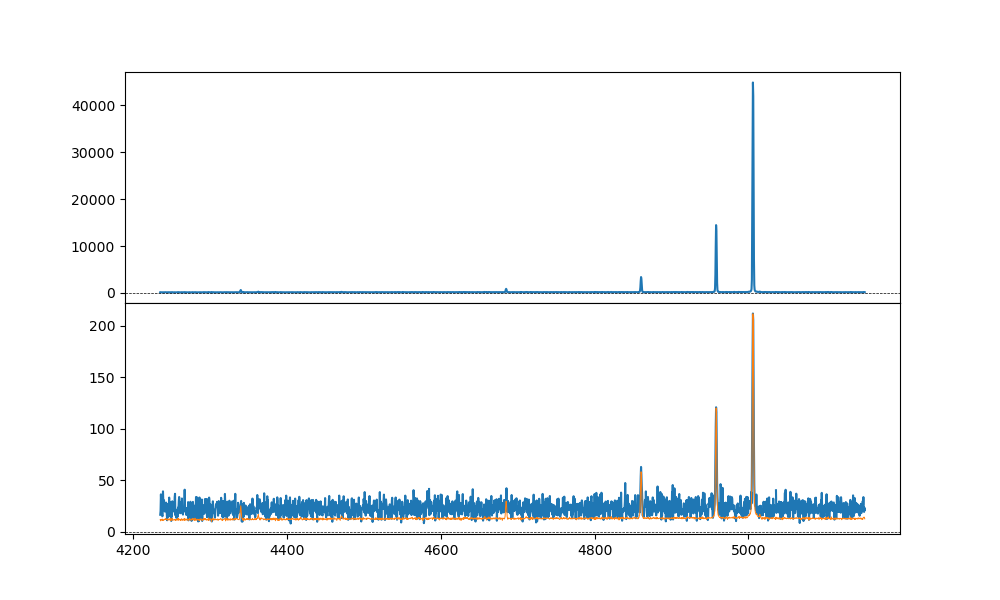

In [19]:
# Plot the spectrum and its uncertainty
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})
fig.subplots_adjust(hspace=0)
# science spectrum
ax1.plot(sci_fw_tab['wavelength'], sci_fw_tab['flux'])
ax1.axhline(0., ls='--', c='k', lw=.5)
# associated uncertainty'
ax2.plot(sci_fw_tab['wavelength'], sci_fw_tab['uncertainty'])
ax2.plot(sci_fw_tab['wavelength'], np.sqrt(sci_fw_tab['flux']), lw=0.7)
ax2.axhline(0., ls='--', c='k', lw=.5)
#ax2.set_xlim(0,1.e3)
plt.show()

In [20]:
# First method to load only binary table data
spec1d = QTable.read('reduced/'+fname_sci_fw)
print(spec1d)

    wavelength            flux           uncertainty    
     Angstrom                                           
------------------ ------------------ ------------------
 5151.245581641957 155.98778745089578 21.047596108271797
5150.7979309463535  176.5474393769349  23.31412982408422
 5150.350280253266 201.28913251128807 19.190367207586743
 5149.902629562694 188.30633713968209 24.181758027777256
 5149.454978874636  192.3228675348646 33.588352307461136
 5149.007328189095 171.37976575446123  26.35173804296995
 5148.559677506068 140.24254356747585 29.632496936313732
 5148.112026825556 159.25803601107427  20.27618638641282
  5147.66437614756 144.92719136443958 20.302680296515963
 5147.216725472078 171.07053434605518 24.619338205399984
               ...                ...                ...
 4238.938684825237 120.38606826367655  28.78222565873803
 4238.491039255625 135.44199421307505  39.16722827691086
 4238.043393688528 122.27826705371115  15.48311632648931
4237.5957481239475  151.7042432

In [21]:
# Second method to retrieve metadata info as well
spec1d = pf.open('reduced/'+fname_sci_fw, ignore_missing_end=True)
print(spec1d.info())
print('\n')
print(spec1d[0].header)
print('\n')
print(spec1d[1].header)
print('\n')
print(type(spec1d[1]))

Filename: reduced/Master_M76_fw_s1d.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   ()      
  1                1 BinTableHDU     15   2048R x 3C   [D, D, D]   
None


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H HEAD    = 'DU940P_BV'          / Head model                                     ACQMODE = 'Single Scan'        / Acquisition mode                               READMODE= 'Image   '           / Readout mode                                   IMGRECT = '1, 2048, 512, 1'    / Image format       



XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   24 / length of dimension 1                          NAXIS2  =                 2048 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'wavelength'                                                          TFORM1  = 'D       '                                                            TUNIT1  = 'Angstrom'                                                            TTYPE2  = 'flux    '                                                            TFORM2  = 'D       '                  